Creating a model to predict if a patient has heart disease or not.
Data dictionary

* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal]


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import pipeline
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import neighbors
from xgboost import XGBClassifier
from sklearn import metrics

In [2]:
def threshhold_and_plot(y_test, target, n_points=50, plot=True):
    """
    :param y_test: binary vector of actual targets
    :param target: vector of probabilities
    :param n_points: number of points to evaluate for a threshold
    :param plot: Boolean; whether or not to plot the results
    :return: vector of values of precision, recall, F1 for given points
    """
    # plot the value of the metric against the threshold
    #plt.figure(figsize=(12,12))
    probs = np.linspace(0, 1, n_points)
    def make_thresh():  # try n_points = 50 or 100...
        # calculate each metric here
        precision = [metrics.precision_score(y_test, np.where(target > thresh, 1, 0),zero_division=1)
                     for thresh in probs]
        recall = [metrics.recall_score(y_test, np.where(target > thresh, 1, 0),zero_division=1)
                  for thresh in probs]
        f1 = [metrics.f1_score(y_test, np.where(target > thresh, 1, 0),zero_division=1)
              for thresh in probs]
        roc_auc = [metrics.roc_auc_score(y_test,np.where(target > thresh,1,0))
                   for thresh in probs]
       
        return precision, recall, f1, roc_auc

    precision, recall, f1, roc_auc = make_thresh()

    
    if plot:
        plt.plot(probs, precision, label='precision')
        plt.plot(probs, recall, label='recall')
        plt.plot(probs, f1, label='f1')
        plt.plot(probs, roc_auc, label="roc auc")
        # plt.plot(probs, pr_auc, label="pr auc")
        plt.title("Metrics at various thresholds");
        plt.xlabel("Probability");
        plt.legend();
        return precision, recall, f1, roc_auc
    else:
        return precision, recall, f1, roc_auc

def max_thresh(score_vec):
  # can either unpack a tuple or feed in iterable by itself
    max_idx = np.argmax(score_vec)
    max_score = score_vec[max_idx]
    return max_idx, max_score

In [3]:
def plot_Confusionmatrix(actuals,target):
    plt.figure(figsize=(5,4))
    ConfMatrix = metrics.confusion_matrix(actuals,target, labels=[0,1], normalize='true')
    
    sns.heatmap(ConfMatrix,annot=True, cmap="Blues", 
                xticklabels = ["0","1"], 
                yticklabels = ["0","1"])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix");
    return

In [4]:
df_hf = pd.read_csv('../Data/heart.csv',header = 0)

In [5]:
df_hf.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
df_hf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
df_hf.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [8]:
#Count the number of missing values in each column and sort them.
missing = pd.concat([df_hf.isnull().mean(), 100 * df_hf.isnull().mean()],axis=1)
missing.columns=['count','%']
missing.sort_values(by= 'count', ascending=False)

,count,%
Age,0.0,0.0
Sex,0.0,0.0
ChestPainType,0.0,0.0
RestingBP,0.0,0.0
Cholesterol,0.0,0.0
FastingBS,0.0,0.0
RestingECG,0.0,0.0
MaxHR,0.0,0.0
ExerciseAngina,0.0,0.0
Oldpeak,0.0,0.0


No missing values

In [9]:
# Checking for nunique value in the data attributes
df_hf.nunique().sort_values(ascending = False)

Cholesterol       222
MaxHR             119
RestingBP          67
Oldpeak            53
Age                50
ChestPainType       4
RestingECG          3
ST_Slope            3
Sex                 2
FastingBS           2
ExerciseAngina      2
HeartDisease        2
dtype: int64

In [10]:
#unique values and their relative frequency for Age
pd.DataFrame({"Relative Frequency for Sex": df_hf['Sex'].value_counts(normalize=True)})

,Relative Frequency for Sex
M,0.78976
F,0.21024


In [11]:
#unique values and their relative frequency for Age
pd.DataFrame({"Relative Frequency for Chest Pain Type": df_hf['ChestPainType'].value_counts(normalize=True)})

,Relative Frequency for Chest Pain Type
ASY,0.540305
NAP,0.221133
ATA,0.188453
TA,0.050109


In [12]:
#unique values and their relative frequency for Age
pd.DataFrame({"Relative Frequency for Resting ECG": df_hf['RestingECG'].value_counts(normalize=True)})

,Relative Frequency for Resting ECG
Normal,0.601307
LVH,0.204793
ST,0.193900


In [13]:
#unique values and their relative frequency for Age
pd.DataFrame({"Relative Frequency for ST_Slope": df_hf['ST_Slope'].value_counts(normalize=True)})

,Relative Frequency for ST_Slope
Flat,0.501089
Up,0.430283
Down,0.068627


In [14]:
#unique values and their relative frequency for Age
pd.DataFrame({"Relative Frequency for FastingBS": df_hf['FastingBS'].value_counts(normalize=True)})

,Relative Frequency for FastingBS
0,0.766885
1,0.233115


In [15]:
#unique values and their relative frequency for Age
pd.DataFrame({"Relative Frequency for ExerciseAngina": df_hf['ExerciseAngina'].value_counts(normalize=True)})

,Relative Frequency for ExerciseAngina
N,0.595861
Y,0.404139


In [16]:
#unique values and their relative frequency for Age
pd.DataFrame({"Relative Frequency for HeartDisease": df_hf['HeartDisease'].value_counts(normalize=True)})

,Relative Frequency for HeartDisease
1,0.553377
0,0.446623


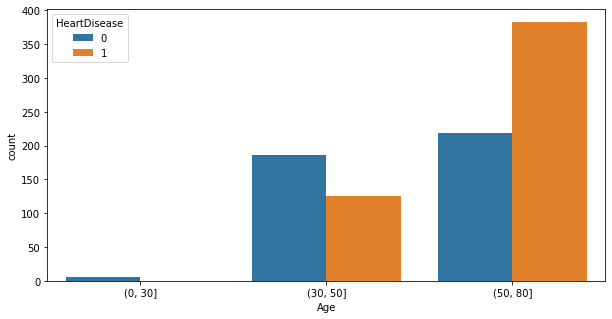

In [17]:
#Age
plt.figure(figsize=(10,5))
bins=[0,30,50,80]
sns.countplot(x=pd.cut(df_hf.Age,bins=bins),hue=df_hf.HeartDisease)
plt.show()

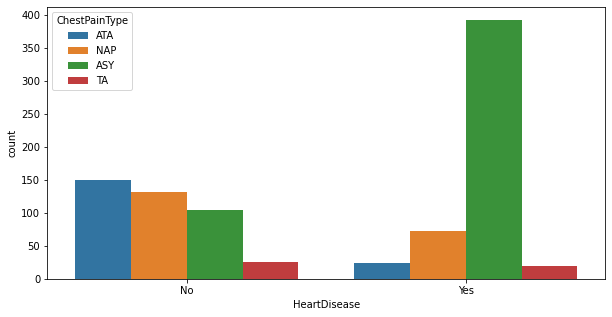

In [18]:
#Chest pain type :
#TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic
plt.figure(figsize=(10,5))
sns.countplot(x=df_hf.HeartDisease,hue=df_hf.ChestPainType)
plt.xticks(np.arange(2), ['No', 'Yes']) 
plt.show()

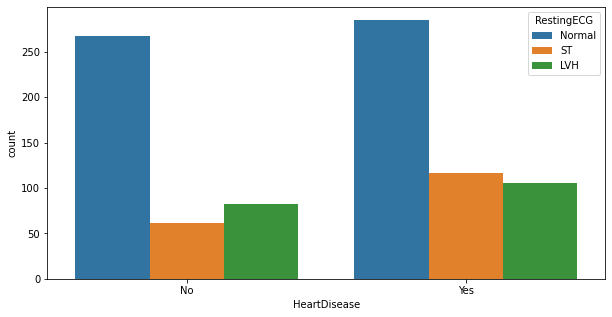

In [19]:
#RestingECG : Resting electrocardiogram results
plt.figure(figsize=(10,5))
sns.countplot(x=df_hf.HeartDisease,hue=df_hf.RestingECG)
plt.xticks(np.arange(2), ['No', 'Yes']) 
plt.show()

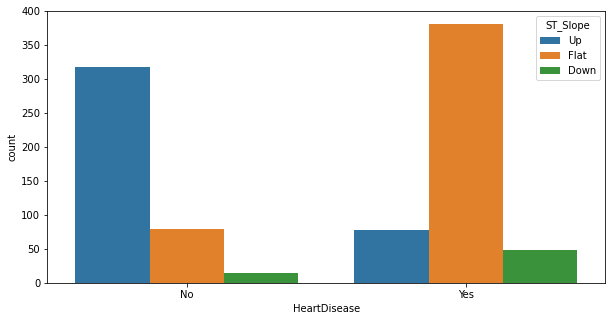

In [20]:
#ST_Slope
plt.figure(figsize=(10,5))
sns.countplot(x=df_hf.HeartDisease,hue=df_hf.ST_Slope)
plt.xticks(np.arange(2), ['No', 'Yes']) 
plt.show()

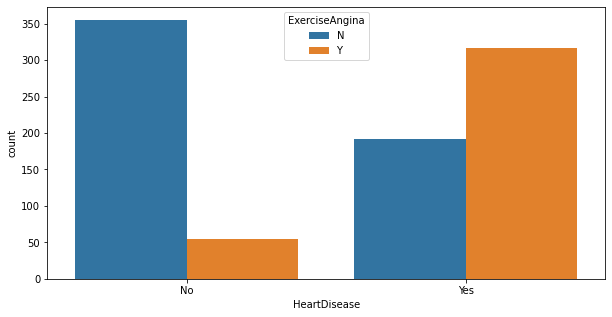

In [21]:
#ExerciseAngina:Exercise-induced angina
plt.figure(figsize=(10,5))
sns.countplot(x=df_hf.HeartDisease,hue=df_hf.ExerciseAngina)
plt.xticks(np.arange(2), ['No', 'Yes']) 
plt.show()

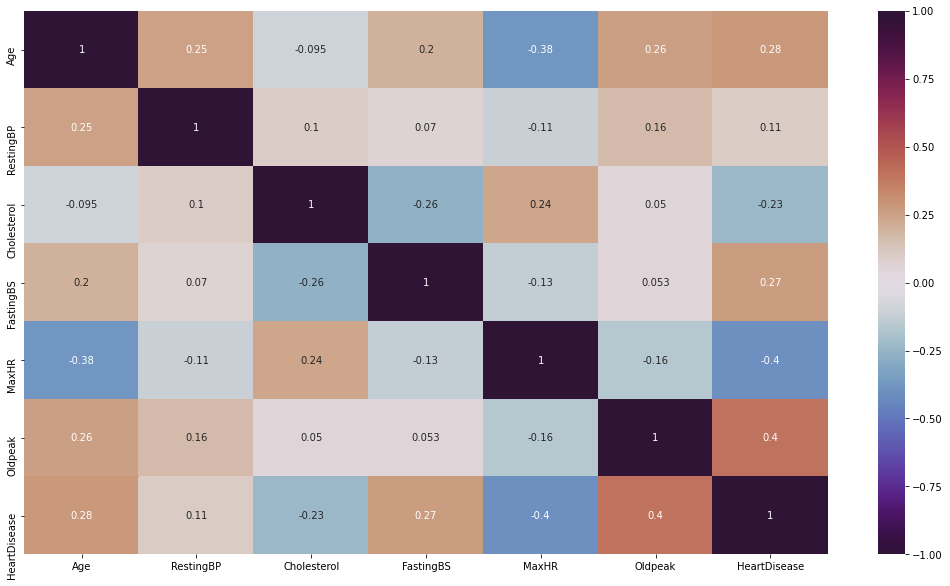

In [22]:
df_hf.corr()
fig, ax = plt.subplots(figsize=(18,10))
list_cols = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease']
    
sns.heatmap(df_hf[list_cols].corr(),cmap="twilight_shifted",annot=True,vmin=-1, vmax=1, center= 0,linewidths=3, linecolor='none',ax=ax)
plt.show()

All features are kept, there is no strong feature interaction

Pre-Processing

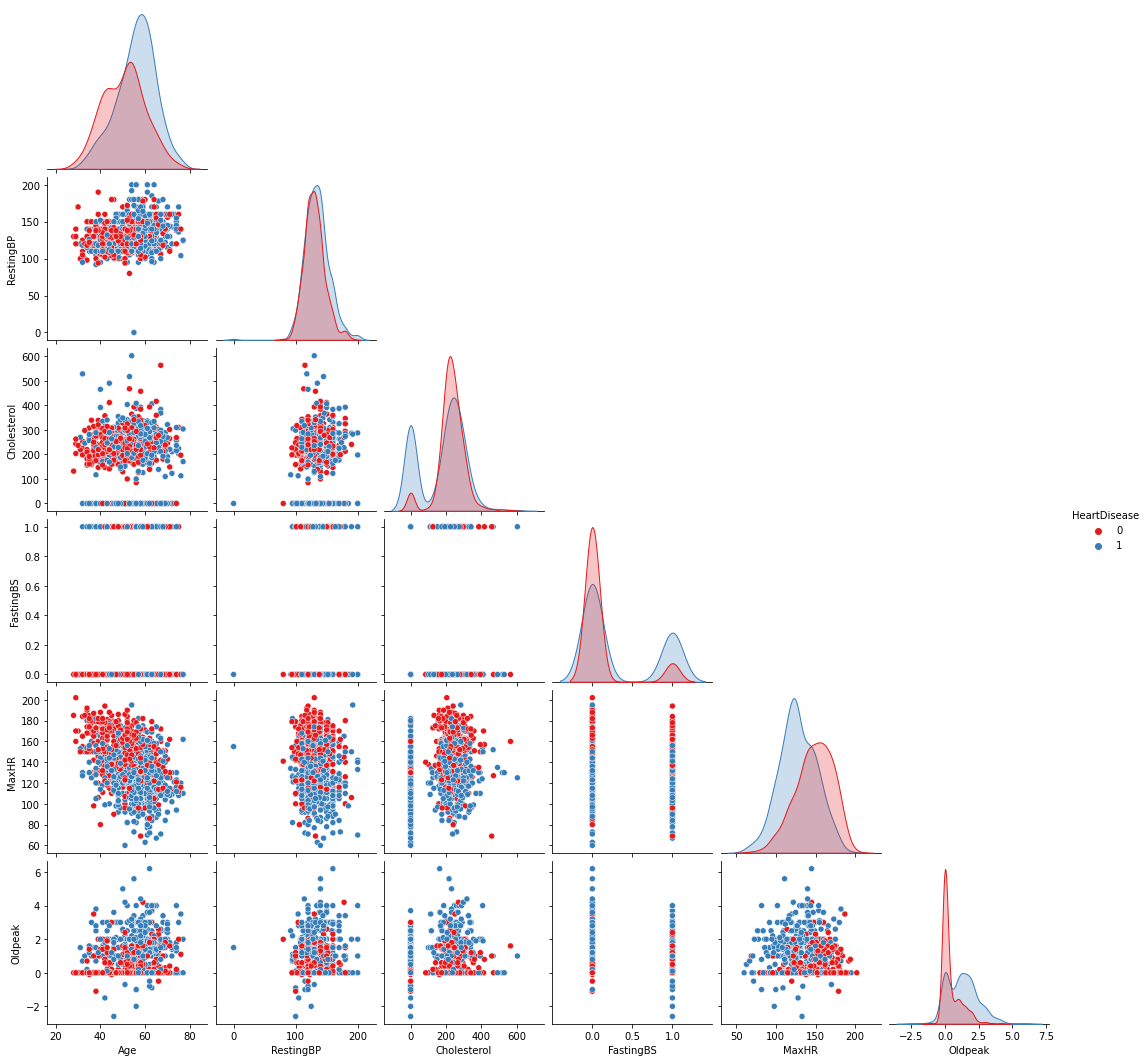

In [23]:
#Corralation

list_cols = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease']
sns.set_palette(sns.color_palette("Set1", 8))
sns.pairplot(df_hf[list_cols], hue="HeartDisease",corner=True)
plt.show()

In [24]:
def binaryencode(df,value,col):
    df = df.copy()
    df[col] = df[col].apply(lambda x:1 if x == value else 0)
    return df
    
def onehotencode(df,col,prefix):
    df = df.copy()
    onehot_dummies = pd.get_dummies(df[col],prefix=prefix)
    df = pd.concat([df,onehot_dummies],axis=1)
    return df

def ordinalencode(df, col,order):
    df = df.copy()
    df[col] = df[col].apply(lambda x: order.index(x))
    return df

In [25]:
def pre_processing(df):
    df = df.copy()
    
    #binary column encoding
    df = binaryencode(df,'M','Sex')
    
    df = onehotencode(df,"ChestPainType","CP")
    df = onehotencode(df,"RestingECG","RECG")
    df = onehotencode(df,"ST_Slope","SL")
    df = onehotencode(df,"RestingECG","RECG")
    df = onehotencode(df,"ExerciseAngina","EA")

    y = df['HeartDisease']
    X = df.drop(['HeartDisease','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'],axis=1)

    return X,y

In [26]:
X, y = pre_processing(df_hf)

In [27]:
X.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,CP_ASY,CP_ATA,CP_NAP,...,RECG_Normal,RECG_ST,SL_Down,SL_Flat,SL_Up,RECG_LVH,RECG_Normal,RECG_ST,EA_N,EA_Y
0,40,1,140,289,0,172,0.0,0,1,0,...,1,0,0,0,1,0,1,0,1,0
1,49,0,160,180,0,156,1.0,0,0,1,...,1,0,0,1,0,0,1,0,1,0
2,37,1,130,283,0,98,0.0,0,1,0,...,0,1,0,0,1,0,0,1,1,0
3,48,0,138,214,0,108,1.5,1,0,0,...,1,0,0,1,0,0,1,0,0,1
4,54,1,150,195,0,122,0.0,0,0,1,...,1,0,0,0,1,0,1,0,1,0


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [29]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Models

In [55]:
# rand search function
def rand_search(X_train,y_train,parameters,model,n_iter=100):
    #pipeline
    clf_pipeline = pipeline.Pipeline([("clf",model)])
    #Grid search CV
    scoring = 'recall'
    verbose = 1
    clf_rand = model_selection.RandomizedSearchCV(clf_pipeline, parameters, n_iter = n_iter,scoring=scoring,verbose = verbose, random_state=1,n_jobs=-1)
    #Learn from training
    clf_rand.fit(X_train,y_train)  #learn the training set
    
    print("Best parameters for ", model) 
    print(clf_rand.best_params_)
    print(f"\nBest train %s score: {clf_rand.best_score_ :.2f}" % (scoring))
    return clf_rand.best_estimator_

# grid search function
def grid_search(X_train,y_train,parameters,model):
    
    #pipeline
    clf_pipeline = pipeline.Pipeline([("clf",model)])   #Pipeline applies scaling and model estimator
    #Grid search CV
    scoring = 'recall'
    verbose = 1
    clf_grid = model_selection.GridSearchCV(clf_pipeline, parameters,  scoring=scoring,verbose = verbose)
    #Learn from training
    clf_grid.fit(X_train,y_train) 

    print("Best parameters for ", model) 
    print(clf_grid.best_params_)
    print(f"\nBest train %s score: {clf_grid.best_score_ :.2f}" % (scoring))
    return clf_grid.best_estimator_

In [32]:
#classifier
clf_lg = linear_model.LogisticRegression(fit_intercept= True,max_iter=500,random_state=632966)

# Grid of parameters
model_params_lg = {"model__C": (np.logspace(start=-4,stop=4,num=30)),
                   'model__penalty': ['l2']} 
#'model__solver' : ['liblinear','newton-cg','lbfgs','sag','saga'],

# pipeline
model_pipeline_lg = pipeline.Pipeline(steps=[("model",clf_lg)])

cross_validator = (model_selection.StratifiedShuffleSplit(train_size=0.8,random_state=1337,n_splits=50))

# set up grid search
model_grid_lg = (
  model_selection.GridSearchCV(estimator=model_pipeline_lg,
                               param_grid=model_params_lg,
                               refit=True, # refit using best estimates
                               scoring="recall", cv=cross_validator,n_jobs = -1,verbose=1))

In [34]:
%%time
#fit on Train set
lg_mod = model_grid_lg.fit(X_train,y_train)

Fitting 50 folds for each of 30 candidates, totalling 1500 fits
Wall time: 2.1 s


In [35]:
log_best_estimator = lg_mod.best_estimator_
log_best_estimator

Pipeline(steps=[('model',
                 LogisticRegression(C=0.0001, max_iter=500,
                                    random_state=632966))])

In [36]:
print(f"Best params {lg_mod.best_params_} \nBest score {lg_mod.best_score_ }")

Best params {'model__C': 0.0001, 'model__penalty': 'l2'} 
Best score 1.0


In [37]:
#cross validation
lr_cv_scores = (
    model_selection.cross_val_score(log_best_estimator,
                                      X_train,
                                      y_train,
                                      scoring="recall",
                                      cv=cross_validator,
                                      n_jobs=-1))

In [38]:
cv_quantiles = np.quantile(a=lr_cv_scores,q=[0.025,0.975])
print(f" Performance on training set is in range between {cv_quantiles[0]:.3f} to {cv_quantiles[1]:.3f},with average roc_auc:{lr_cv_scores.mean():.3f}")

 Performance on training set is in range between 1.000 to 1.000,with average roc_auc:1.000


<AxesSubplot:ylabel='Count'>

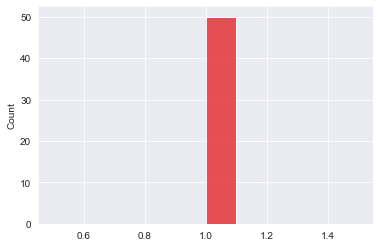

In [39]:
sns.set_style("darkgrid")
sns.histplot(lr_cv_scores, bins=10)

In [40]:
y_proba_lg = log_best_estimator.predict_proba(X_train)
y_proba_lg = y_proba_lg[:,1]

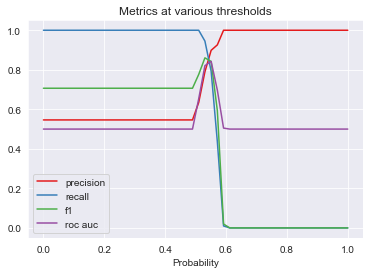

In [41]:
lg_prec, lg_rec, lg_f1, lg_roc_auc = threshhold_and_plot(y_train,y_proba_lg)

In [42]:
lg_thresh_idx, lg_max_score = max_thresh(lg_roc_auc)
#print(f'max_roc_auc is: {lg_max_score :.4f}')
print(f'max_roc_auc is: {lg_max_score}')

max_roc_auc is: 0.8424546741254971


In [43]:
#Apply threshold on train set

In [44]:
lg_train_labels = np.where(y_proba_lg >= lg_max_score, 1, 0)

LG classification report on train set
               precision    recall  f1-score   support

           0       0.45      1.00      0.62       333
           1       1.00      0.00      0.00       401

    accuracy                           0.45       734
   macro avg       0.73      0.50      0.31       734
weighted avg       0.75      0.45      0.28       734



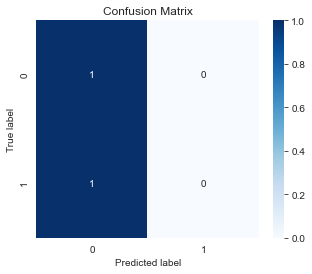

In [45]:
plot_Confusionmatrix(y_train,lg_train_labels)
y_class_report = metrics.classification_report(y_train,lg_train_labels,zero_division=1, target_names=["0","1"])
print("LG classification report on train set\n", y_class_report )

Apply threshold on test set

In [46]:
lg_test_predict = log_best_estimator.predict_proba(X_test)
lg_test_labels = np.where(lg_test_predict[:,1] >= lg_max_score, 1, 0)

In [47]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test,lg_test_labels).ravel()
print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

True -ve : 77
False +ve : 0
False -ve : 107
True +ve : 0



LG classification report on test set
               precision    recall  f1-score   support

           0       0.42      1.00      0.59        77
           1       1.00      0.00      0.00       107

    accuracy                           0.42       184
   macro avg       0.71      0.50      0.30       184
weighted avg       0.76      0.42      0.25       184



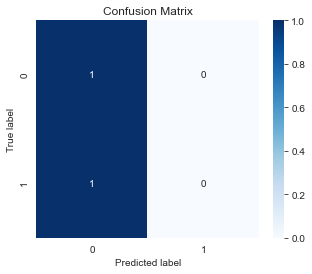

In [48]:
plot_Confusionmatrix(y_test,lg_test_labels)
y_class_report = metrics.classification_report(y_test,lg_test_labels,zero_division=1, target_names=["0","1"])
print("LG classification report on test set\n", y_class_report )

In [51]:
AccScore = metrics.accuracy_score(y_test, lg_test_labels, normalize=False)
print('Accuracy Score is : ', AccScore)
F1Score = metrics.f1_score(y_test, lg_test_labels, average='micro') #it can be : binary,macro,weighted,samples
print('F1 Score is : ', F1Score)

Accuracy Score is :  77
F1 Score is :  0.41847826086956524


Model performed well enough for no disease but for predicted fairly with heard disease.

Random Forest Classification

In [52]:
#Setting ranges for each parameter.
clf__max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
rfc_params = {"clf__n_estimators": np.linspace(start = 100, stop = 1000, num = 10,dtype=int),
              "clf__min_samples_split": np.arange(2,6), 
              "clf__max_features":["sqrt", "log2"],
              "clf__max_depth": clf__max_depth
             }

In [ ]:
%%time
classifier=ensemble.RandomForestClassifier(random_state=1,n_jobs=-1)
rfc_best_estimator = rand_search(X_train,y_train, rfc_params, classifier,n_iter=120) #apply random search

Fitting 5 folds for each of 120 candidates, totalling 600 fits


In [ ]:
%%time
cv_scores_rfc = (
  model_selection.cross_val_score(rfc_best_estimator,
                                  X_train,
                                  y_train,
                                  scoring="recall",
                                  cv=cross_validator,
                                  n_jobs=-1))

In [ ]:
cv_quantiles = np.quantile(a=cv_scores_rfc,q=[0.025,0.975])
print(f" Performance on training set is in range between {cv_quantiles[0]:.3f} to {cv_quantiles[1]:.3f},with average roc_auc:{cv_scores_rfc.mean():.3f}")

In [ ]:
sns.set_style("darkgrid")
sns.histplot(cv_scores_rfc, bins=10)

In [ ]:
y_proba_rfc = rfc_best_estimator.predict_proba(X_train)
y_proba_rfc = y_proba_rfc[:,1]

In [ ]:
rfc_prec, rfc_rec, rfc_f1, rfc_roc_auc = threshhold_and_plot(y_train,y_proba_rfc)

In [ ]:
rfc_thresh_idx, rfc_max_score = max_thresh(rfc_roc_auc)
print(f'max_roc_auc is: {rfc_max_score}')

Apply threshold on train set

In [ ]:
rfc_train_labels = np.where(y_proba_rfc >= rfc_max_score, 1, 0)

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_train,rfc_train_labels).ravel()
print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

In [ ]:
plot_Confusionmatrix(y_train,rfc_train_labels)
y_class_report = metrics.classification_report(y_train,rfc_train_labels,zero_division=1, target_names=["0","1"])
print("RF classification report on train set\n", y_class_report )

Apply threshold on test set

In [ ]:
rfc_test_predict = rfc_best_estimator.predict_proba(X_test)

In [ ]:
rfc_test_labels = np.where(rfc_test_predict[:,1] >= rfc_max_score, 1, 0)

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test,rfc_test_labels).ravel()
print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

In [ ]:
plot_Confusionmatrix(y_test,rfc_test_labels)
y_class_report = metrics.classification_report(y_test,rfc_test_labels,zero_division=1, target_names=["0","1"])
print("RF classification report on test set\n", y_class_report )

In [ ]:
AccScore = accuracy_score(y_test, rfc_test_labels, normalize=False)
print('Accuracy Score is : ', AccScore)
F1Score = f1_score(y_test, rfc_test_labels, average='micro') #it can be : binary,macro,weighted,samples
print('F1 Score is : ', F1Score)

XGBoost Classification

In [ ]:
#Settingranges for the hyperparameter are shown below.
xgb_params = {"clf__learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
               "clf__max_depth": np.arange(2,7),
               "clf__min_child_weight": np.arange(1,11),
               "clf__reg_lambda": np.linspace(0.1,1,num=10)
              }

In [ ]:
%%time
classifier = XGBClassifier(booster="gbtree", verbosity=0, use_label_encoder=False,n_jobs=-1)

xgb_best_estimator = rand_search(X_train,y_train, xgb_params,classifier,n_iter=120)

In [ ]:
%%time
cv_scores_xgb = (
  model_selection.cross_val_score(xgb_best_estimator,
                                  X_train,
                                  y_train,
                                  scoring="recall",
                                  cv=cross_validator,
                                  n_jobs=-1))

In [ ]:
cv_quantiles = np.quantile(a=cv_scores_xgb,q=[0.025,0.975])
print(f" Performance on training set is in range between {cv_quantiles[0]:.3f} to {cv_quantiles[1]:.3f},with average roc_auc:{cv_scores_xgb.mean():.3f}")

In [ ]:
sns.set_style("darkgrid")
sns.histplot(cv_scores_xgb, bins=10)

Get threshold using train set

In [ ]:
#use train data to get threshold for roc_auc
y_proba_xgb = xgb_best_estimator.predict_proba(X_train)
y_proba_xgb = y_proba_xgb[:,1]

In [ ]:
xgb_prec, xgb_rec, xgb_f1, xgb_roc_auc = threshhold_and_plot(y_train,y_proba_xgb)

In [ ]:
xgb_thresh_idx, xgb_max_score = max_thresh(xgb_roc_auc)
print(f'max_roc_auc is: {xgb_max_score}')

Apply threshold on train set

In [ ]:
xgb_train_labels = np.where(y_proba_xgb >= xgb_max_score, 1, 0)

In [ ]:
#tn, fp, fn, tp = metrics.confusion_matrix(y_train,lg_train_labels).ravel()
#print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

In [ ]:
plot_Confusionmatrix(y_train,xgb_train_labels)
y_class_report = metrics.classification_report(y_train,xgb_train_labels,zero_division=1, target_names=["0","1"])
print("classification report\n", y_class_report )

Apply threshold on test set

In [ ]:
xgb_test_predict = xgb_best_estimator.predict_proba(X_test)

In [ ]:
xgb_test_labels = np.where(xgb_test_predict[:,1] >= xgb_max_score, 1, 0)

In [ ]:
#tn, fp, fn, tp = metrics.confusion_matrix(y_test,lg_test_labels).ravel()
#print(f"True -ve : {tn}\nFalse +ve : {fp}\nFalse -ve : {fn}\nTrue +ve : {tp}\n")

In [ ]:
plot_Confusionmatrix(y_test,xgb_test_labels)
y_class_report = metrics.classification_report(y_test,xgb_test_labels,zero_division=1, target_names=["0","1"])
print("classification report\n", y_class_report )

In [ ]:
AccScore = accuracy_score(y_test, xgb_test_labels, normalize=False)
print('Accuracy Score is : ', AccScore)
F1Score = f1_score(y_test, xgb_test_labels, average='micro') #it can be : binary,macro,weighted,samples
print('F1 Score is : ', F1Score)

ROC_AUC Curve Comparison

In [ ]:
#on Train set
fig = metrics.RocCurveDisplay.from_predictions(y_train, xgb_train_labels, name='XGB')
fig = metrics.RocCurveDisplay.from_predictions(y_train, lg_train_labels, ax = fig.ax_,name='LR')
fig = metrics.RocCurveDisplay.from_predictions(y_train, rfc_train_labels, ax = fig.ax_,name='RFC')
plt.show()

In [ ]:
#on test set
fig = metrics.RocCurveDisplay.from_predictions(y_test, xgb_test_labels,name='XGB')
fig = metrics.RocCurveDisplay.from_predictions(y_test, lg_test_labels, ax = fig.ax_,name='LR')
fig = metrics.RocCurveDisplay.from_predictions(y_test, rfc_test_labels, ax = fig.ax_,name='RFC')
plt.show()

Logistic regression is peformed well. However accuracy needs to be improved. 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [ ]:
pca = PCA()

pipeline = make_pipeline(sc, pca) #Sc - std scaler

pipeline.fit(X_train)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

5 or 6 components. we can go with

In [ ]:
pca = PCA(n_components = 5)
pca.fit(X_train)
pca_features = pca.transform(X_train)
print(pca_features.shape)

SVM model

In [ ]:
from sklearn import svm
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV
from sklearn.metrics import roc_auc_score

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='poly'),
          svm.SVC(kernel='sigmoid'),
          svm.SVC(kernel='rbf')]

In [ ]:
KFold_Score = pd.DataFrame()
classifiers = ['Linear SVM', 'Poly SVM', 'Sigmoid SVM', 'Rbf SVM']
j = 0
for i in models:
    model = i
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    KFold_Score[classifiers[j]] = (cross_val_score(model, X_train, y_train, scoring = 'recall', cv=cv))
    j = j+1

In [ ]:
mean = pd.DataFrame(KFold_Score.mean(), index= classifiers)
KFold_Score = pd.concat([KFold_Score,mean.T])
KFold_Score.index=['Fold 1','Fold 2','Fold 3','Fold 4', 'Fold 5', 'Mean']
KFold_Score.T.sort_values(by=['Mean'], ascending = False)

In [ ]:
params = {
    "C": [1, 10],
    "gamma": [0.001, 0.01, 1],
}
svm_grid = GridSearchCV(svm.SVC(kernel='rbf'), params, cv=3, scoring='recall')
svm_grid.fit(X_train, y_train)

In [ ]:
print("Best estimator:",svm_grid.best_estimator_)
print("Best score:", svm_grid.best_score_)

In [ ]:
model_svm = svm.SVC(kernel="rbf", C=1, gamma=1)
model_svm.fit(X_train, y_train)

In [ ]:
y_pred = model_svm.predict(X_test)

In [ ]:
print("Recall score |", recall_score(y_test, y_pred))
print("Accuracy score |", accuracy_score(y_test, y_pred))
print("F1-score |", f1_score(y_test, y_pred))
print("Area under curve score | ", roc_auc_score(y_test, y_pred))